In [248]:
import matplotlib.pyplot as plt
import pandas as pd
import advertools as adv
import tweepy, re, time, json, os, emojis, nltk
from IPython.display import Image, display, Markdown
from wordcloud import WordCloud
from collections import namedtuple, Counter
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
pd.set_option('display.max_colwidth', 140)

In [249]:
nltk.download('stopwords')
nltk.download('wordnet')
spanish_stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [210]:
### API X.com
consumer_key = 'PhlbP0ijLI4UcUOoJ3V4h5YLA'
consumer_secret = 'ely9TEKgzo2JsRPGNNrcBe9vmLcXwZZK94AK6vayk7cm0n6AXK'
access_token = '186808723-ck2WhAajeKTvClkpXazsR5FqTzNUxrgROMDP9SHx'
access_token_secret = 'QLZGpTNjGt2bqS7jmvmwS9BWsLpwhic485Yqai3DmIdIH'

### Creacion de REGEX para emoticons

In [52]:
with open('emoji-test.txt', 'rt', encoding='UTF-8') as file:
    emoji_raw = file.read()

In [53]:
EmojiEntry = namedtuple('EmojiEntry', ['codepoint', 'status', 'emoji', 'name', 'group', 'sub_group'])

In [54]:
E_regex = re.compile(r' ?E\d+\.\d+ ') # remove the pattern E<digit(s)>.<digit(s)>
emoji_entries = []

for line in emoji_raw.splitlines()[32:]:  # skip the explanation lines
    if line == '# Status Counts':  # the last line in the document
        break
    if 'subtotal:' in line:  # these are lines showing statistics about each group, not needed
        continue
    if not line:  # if it's a blank line
        continue
    if line.startswith('#'):  # these lines contain group and/or sub-group names
        if '# group:' in line:
            group = line.split(':')[-1].strip()
        if '# subgroup:' in line:
            subgroup = line.split(':')[-1].strip()
    if group == 'Component':  # skin tones, and hair types, skip, as mentioned above
        continue
    if re.search('^[0-9A-F]{3,}', line):  # if the line starts with a hexadecimal number (an emoji code point)
        # here we define all the elements that will go into emoji entries
        codepoint = line.split(';')[0].strip()  # in some cases it is one and in others multiple code points
        status = line.split(';')[-1].split()[0].strip() # status: fully-qualified, minimally-qualified, unqualified
        if line[-1] == '#':
            # The special case where the emoji is actually the hash sign "#". In this case manually assign the emoji
            if 'fully-qualified' in line:
                emoji = '#️⃣'
            else:
                emoji = '#⃣'  # they look the same, but are actually different 
        else:  # the default case
            emoji = line.split('#')[-1].split()[0].strip()  # the emoji character itself
        if line[-1] == '#':  # (the special case)
            name = '#'
        else:  # extract the emoji name
            split_hash = line.split('#')[1]
            rm_capital_E = E_regex.split(split_hash)[1]
            name = rm_capital_E
        templine = EmojiEntry(codepoint=codepoint,
                              status=status,
                              emoji=emoji,
                              name=name,
                              group=group,
                              sub_group=subgroup)
        emoji_entries.append(templine)

In [55]:
emoji_dict = {x.emoji: x for x in emoji_entries}

In [57]:
Counter([x.group for x in emoji_entries])

Counter({'People & Body': 2998,
         'Objects': 310,
         'Symbols': 304,
         'Flags': 275,
         'Travel & Places': 267,
         'Smileys & Emotion': 180,
         'Animals & Nature': 159,
         'Food & Drink': 135,
         'Activities': 96})

In [58]:
sorted(Counter([x.sub_group for x in emoji_entries]).items(), key=lambda x: x[1], reverse=True)[:30]

[('person-role', 635),
 ('family', 534),
 ('person-sport', 395),
 ('person-activity', 318),
 ('person-gesture', 300),
 ('country-flag', 258),
 ('person-fantasy', 245),
 ('person', 192),
 ('animal-mammal', 68),
 ('hand-fingers-open', 67),
 ('sky & weather', 65),
 ('hands', 62),
 ('hand-fingers-partial', 55),
 ('transport-ground', 55),
 ('clothing', 50),
 ('body-parts', 49),
 ('alphanum', 49),
 ('hand-single-finger', 43),
 ('person-resting', 42),
 ('geometric', 38),
 ('hand-fingers-closed', 36),
 ('tool', 35),
 ('arrow', 35),
 ('food-prepared', 34),
 ('time', 34),
 ('av-symbol', 34),
 ('other-symbol', 33),
 ('place-building', 32),
 ('office', 31),
 ('game', 30)]

In [59]:
multi_codepoint_emoji = []

for code in [c.codepoint.split() for c in emoji_entries]:
    if len(code) > 1:
        # turn to a hexadecimal number zfilled to 8 zeros e.g: '\U0001F44D'
        hexified_codes = [r'\U' + x.zfill(8) for x in code]  
        hexified_codes = ''.join(hexified_codes)  # join all hexadecimal components 
        multi_codepoint_emoji.append(hexified_codes)

# sorting by length in decreasing order is extremely important as demonstrated above
multi_codepoint_emoji_sorted = sorted(multi_codepoint_emoji, key=len, reverse=True)

# join with a "|" to function as an "or" in the regex
multi_codepoint_emoji_joined = '|'.join(multi_codepoint_emoji_sorted)

In [60]:
single_codepoint_emoji = []

for code in [c.codepoint.split() for c in emoji_entries]:
    if len(code) == 1:
        single_codepoint_emoji.append(code[0])

In [61]:
def get_ranges(nums):
    """Reduce a list of integers to tuples of local maximums and minimums.

    :param nums: List of integers.
    :return ranges: List of tuples showing local minimums and maximums
    """
    nums = sorted(nums)
    lows = [nums[0]]
    highs = []
    if nums[1] - nums[0] > 1:
        highs.append(nums[0])
    for i in range(1, len(nums)-1):
        if (nums[i] - nums[i-1]) > 1:
            lows.append(nums[i])
        if (nums[i + 1] - nums[i]) > 1:
            highs.append(nums[i])
    highs.append(nums[-1])
    if len(highs) > len(lows):
        lows.append(highs[-1])
    return [(l, h) for l, h in zip(lows, highs)]

In [62]:
# We first convert single_codepoint_emoji to integers to make calculations easier
single_codepoint_emoji_int = [int(x, base=16) for x in single_codepoint_emoji]
single_codepoint_emoji_ranges = get_ranges(single_codepoint_emoji_int)

In [63]:
single_codepoint_emoji_raw = r''  # start with an empty raw string
for code in single_codepoint_emoji_ranges:
    if code[0] == code[1]:  # in this case make it a single hexadecimal character
        temp_regex =  r'\U' + hex(code[0])[2:].zfill(8)
        single_codepoint_emoji_raw += temp_regex
    else:
        # otherwise create a character range, joined by '-'
        temp_regex = '-'.join([r'\U' + hex(code[0])[2:].zfill(8), r'\U' + hex(code[1])[2:].zfill(8)])
        single_codepoint_emoji_raw += temp_regex

In [64]:
all_emoji_regex = re.compile(multi_codepoint_emoji_joined + '|' +  r'[' + single_codepoint_emoji_raw + r']')

In [65]:
all_emoji_regex.findall(' '.join([x.emoji for x in emoji_entries])).__len__()

4724

In [66]:
count = 0
found_emoji = set()
for line in emoji_raw.splitlines()[30:]:
    match = all_emoji_regex.findall(line)
    if match:
        if len(match) > 1:
            break
        count += 1
        found_emoji.add(match[0])
        temp_name = [x.name for x in emoji_entries if x.emoji == match[0]][0]
        assert temp_name in line

count, found_emoji.__len__()

(4724, 4724)

In [67]:
with open('emoji_df.csv', 'wt',encoding='utf-8') as file:
    print('emoji;name;group;sub_group;codepoints', file=file)
    for i, em in enumerate(emoji_entries):
        print(f"{em.emoji};{em.name};{em.group};{em.sub_group};{em.codepoint}", file=file)

In [68]:
pd.options.display.max_columns = None
emoji_df = pd.read_csv('emoji_df.csv', sep=';')
emoji_df.to_csv('emoji_df.csv', index=False)
emoji_df = pd.read_csv('emoji_df.csv')

,emoji,name,group,sub_group,codepoints
0,😀,grinning face,Smileys & Emotion,face-smiling,1F600
1,😃,grinning face with big eyes,Smileys & Emotion,face-smiling,1F603
2,😄,grinning face with smiling eyes,Smileys & Emotion,face-smiling,1F604
3,😁,beaming face with smiling eyes,Smileys & Emotion,face-smiling,1F601
4,😆,grinning squinting face,Smileys & Emotion,face-smiling,1F606
...,...,...,...,...,...
4719,🇿🇲,flag: Zambia,Flags,country-flag,1F1FF 1F1F2
4720,🇿🇼,flag: Zimbabwe,Flags,country-flag,1F1FF 1F1FC
4721,🏴󠁧󠁢󠁥󠁮󠁧󠁿,flag: England,Flags,subdivision-flag,1F3F4 E0067 E0062 E0065 E006E E0067 E007F
4722,🏴󠁧󠁢󠁳󠁣󠁴󠁿,flag: Scotland,Flags,subdivision-flag,1F3F4 E0067 E0062 E0073 E0063 E0074 E007F


In [90]:
all_emoji_regex

re.compile(r'\U0001F9D1\U0001F3FB\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FC|\U0001F9D1\U0001F3FB\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FD|\U0001F9D1\U0001F3FB\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FE|\U0001F9D1\U0001F3FB\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FF|\U0001F9D1\U0001F3FC\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FB|\U0001F9D1\U0001F3FC\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FD|\U0001F9D1\U0001F3FC\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FE|\U0001F9D1\U0001F3FC\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FF|\U0001F9D1\U0001F3FD\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U0000200D\U0001F9D1\U0001F3FB|\U0001F9D1\U0001F3FD\U0000200D\U00002764\U0000FE0F\U0000200D\U0001F48B\U000020

In [271]:
url_regex = re.compile(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?')

def clean_tweets(tweet):
    """ 
    removemos handles @user, links https, numeros,
    pasamos a minuscula, removemos numeros, partimos texto,
    eliminamos espacios innecesarios y volvemos a unir texto 

    @return texto limpio
    """
    del_amp = BeautifulSoup(tweet, 'lxml')
    del_amp_text = del_amp.get_text()
    user_removed = re.sub(r'@[A-Za-z0-9]+','',del_amp_text)
    link_removed = re.sub(url_regex,'',user_removed)
    number_removed = re.sub(r'\d+', '', link_removed)
    hashtag_removed = re.sub('#','', number_removed)
    emoticons_removed = re.sub(all_emoji_regex, '',hashtag_removed)
    lower_case = emoticons_removed.lower()
    tok = WordPunctTokenizer()
    words = tok.tokenize(lower_case)
    token_tweet = (' '.join(words)).strip()
    #clean_tweet = ' '.join([word for word in token_tweet.split() if word not in spanish_stop_words])
    return token_tweet

## Bernardo Arévalo

In [272]:
df = pd.read_csv("bernardoArevalo.csv")

In [257]:
df.head(1)

,Unnamed: 0,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,conversationId,hashtags,cashtags,mentionedUsers,links,viewCount,retweetedTweet,quotedTweet,place,coordinates,inReplyToTweetId,inReplyToUser,source,sourceUrl,sourceLabel,media,_type
0,0,1702109621899407575,1702109621899407575,https://twitter.com/eltuitdehoy_/status/1702109621899407575,2023-09-13 23:58:52+00:00,"{'id': 46561608, 'id_str': '46561608', 'url': 'https://twitter.com/eltuitdehoy_', 'username': 'eltuitdehoy_', 'displayname': 'Ing_DIESEL...",es,"@AnonGTReloaded @msemillagt @BArevalodeLeon jajajajajajajaja que PISEN a quien se deje, ya estamos hartos de tanta ignorancia, y estos d...",0,0,2,0,1702088813042954628,[],[],"[{'id': 1419402501212811265, 'username': 'AnonGTReloaded', 'displayname': 'Anon Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}...",[],184.0,NaN,NaN,NaN,NaN,1.702089e+18,"{'id': 1419402501212811265, 'username': 'AnonGTReloaded', 'displayname': 'Anon Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}",snscrape.modules.twitter.Tweet


In [273]:
df['rawContent'].head(10)

0    @AnonGTReloaded @msemillagt @BArevalodeLeon jajajajajajajaja que PISEN a quien se deje, ya estamos hartos de tanta ignorancia, y estos d...
1                   @ASIERVERA @AztecaNoticiaGT @BArevalodeLeon Dos veces lo repitió. Que está actuando al margen de la ley. Seguro está tocado.
2    Paciente de 39 años, dolor lumbar de 1 año tras caída.\n\nHizo 45 sesiones de fisio SIN mejoría. Sugirieron cirugía.\n\nAcudió por 2da o...
3                              @VicZacariasGT @soy_502 @BArevalodeLeon @msemillagt Mi compa la alucina, puro net pareces https://t.co/RvelUHc67W
4    @Igor_Bitkov No le sigan el juego a este ruso invasor en enero solicitamos que @BArevalodeLeon le retire su asilo y su dpi y lo envíe de...
5    Mas sin vergüenzas no pueden ser estos del MP porque no dicen la verdad que el único fin es traerse abajo a @BArevalodeLeon las actitude...
6    @LarRRytO @BArevalodeLeon @DrGiammattei @FCTGuatemala @MPguatemala @OJGuatemala @PDHgt @RaulFalla31 Ojala que caiga el malo\n

In [231]:
def extract_emoticons(text):
    emoticon_pattern = all_emoji_regex
    emoticons = re.findall(emoticon_pattern, text)
    return " ".join(emoticons)
text_corpus_bernardo = ' '.join(df['rawContent'])
emoticons_text_bernardo = " ".join([extract_emoticons(text) for text in text_corpus_bernardo]).replace(" ", "")

In [236]:
bernardo_emoji_freq = adv.word_frequency(df['rawContent'],
                                          df['viewCount'],
                                          regex=all_emoji_regex.pattern).sort_values(by='abs_freq', ascending=False)
bernardo_emoji_freq.head(15)

,word,abs_freq,wtd_freq,rel_value
266,🤣,194,15411.0,79.0
384,🇬🇹,186,NaN,NaN
6,👉🏼,95,72139607.0,759364.0
187,🗳️,89,371514.0,4174.0
12,🚨,82,20203101.0,246379.0
7,👀,54,59897309.0,1109209.0
119,😂,45,1645189.0,36560.0
116,🤔,41,1768593.0,43136.0
244,✝,38,75239.0,1980.0
208,😅,34,284387.0,8364.0


In [221]:
text_corpus_bernardo[:2000]

'@AnonGTReloaded @msemillagt @BArevalodeLeon jajajajajajajaja que PISEN a quien se deje, ya estamos hartos de tanta ignorancia, y estos delincuentes se ven hasta en las grandes empresas...de que se asustan ? @ASIERVERA @AztecaNoticiaGT @BArevalodeLeon Dos veces lo repitió. Que está actuando al margen de la ley. Seguro está tocado. Paciente de 39 años, dolor lumbar de 1 año tras caída.\n\nHizo 45 sesiones de fisio SIN mejoría. Sugirieron cirugía.\n\nAcudió por 2da opinión e iniciamos protocolo robótico:\n\n-Robot ADAMO\n-Robot Láser\n-Robot Descompresión Espinal\n\nMEJORÍA COMPLETA (9 semanas)\n\nUIO☎️📲0999 055 059 https://t.co/CNh0gtdTBw @VicZacariasGT @soy_502 @BArevalodeLeon @msemillagt Mi compa la alucina, puro net pareces https://t.co/RvelUHc67W @Igor_Bitkov No le sigan el juego a este ruso invasor en enero solicitamos que @BArevalodeLeon le retire su asilo y su dpi y lo envíe deportado a las autoridades rusas Mas sin vergüenzas no pueden ser estos del MP porque no dicen la verdad 

In [223]:
emoticons_text_bernardo[:1000]

'☎📲🏆🏴⚽🔮💛😠😠😠📢👌👀👉🤑⚽💰👈🔥🙌🎓🏫📚👀👉🚨🚨⚽🔥👈🎯😎🤷♂😂😡😡®😢📚🌈👀👉🟡🔴🤍⭐🎓✨👀👉☎📲🏆🏴⚽🔮💛🤔🤔👌👀👉⚽🏆🤩🔥🙌🤔🤑👇🎯💹💪💥👀👉☎📲📹📹🙏📸⚽🆚🆚🆚👈🔥🏫👁😭🤡🏆⚔🏴🤔🤔🤔🤔🧩❤💙👩⚕🧑⚕👉🏥🤼♀👑💵🌍👉👩🎓🧑🎓⚽⚫🔵🔴⚫🤩🔥🎯🚀🍔🌐✨📌‼😠😡😠‼👍👍🎊🎉🎊✨🎓💼👀👉➡⚽🏆🤩🔥🤬🧩😬😬😬🚫🛂🤚💹💪💥👀👉☎🤪😱🥴😰😅😠😠😠📢🏰👉✨🔝🤮🧨💰🤼📲🤜🔥🤛📚‼‼🤣🤣🤣🤣🤣🤣🤣🤣😜👷♀🧑🏭👉☎🤪😱🥴😰😅🏰👉✨🔝🙏🙏🙏🥹🪲🐀💩🚀📱👽✨💯💯💯💼👉👩🎓🧑🎓🤑⚽💰👈🔥😡😡😢🤜🤛✨👀👉🥳🏆🎁💸🎡⚽🍀🔞🌐🚀💻🛡🔒🎉💩💩💩💩🖕✨🎓💼👀👉☎🤪😱🥴😰😅⚽🔥🌍💵🏆☕🤷♀✅🗳🌱🥦👉👩🎓🧑🎓⚽🔥👈🎯🤔🤔👌👀👉🕵♂🤖📱💻🙄‼🧨💰🤼📲🤜🔥🤛🚀📱👽✨💼👉👩🎓🧑🎓🟡🔴🤍⭐🙌👩⚕🧑⚕🐶🐱🐷👉🧑🎓🌎🏆😉🤷👩⚕⚡👉🏥🏆🏴⚽🔮💛🏫👁😭🤡🤔🤔🤔❤🦷❤🧑⚕👩⚕🦷⚡🪄🎓🏫📚👀👉🌎🏆👀🎓💼👩💼👨💼👀👉🏆🔥💀🏴📌🎓✨👀👉🔥⚪🟡🔴⚽👈🤣😂🌊🍹🌟🔧👉👩🎓🧑🎓⚽🏆🤩🔥➡🤬😬😬😬🚫🛂🤚💫💥👀👉🚀🤔🤔🤔📚🌈👀👉💥🏦👀🏆⚔🏴🤔🚀🤣🤣🤣🤣🤣🤣🤣🤣🌟🎓👀👉😭😭😭😭✨🚀🎨👉🤣👌🤮🤮🎓💼👩💼👨💼👀👉😜🙏🙏🙏😱💸🧮🚨🔞🚀🐀💩🌟🔧👉👩🎓🧑🎓🤣🤣👏👏👏👏🌍⚽⚔🔮🤡😅😅😅🖥⚡🎨🗂📚💥💰🤣🤣🤣🤣🤣🌱🤡🤣🤣🤣😆🚗👉🚗😎🧨💰🤼📲🤜🔥🤛💵🎉💩💩💩💩🖕🌟😎👉👩🎓🧑🎓🥊👨🤜🔥📣🚀🧠💡🤡📣😂🤣🤣🤣🌟😎👉👩🎓🧑🎓⚽⚫🔵🔴⚫🤩🔥🎯🤷♀✅🗳🎓🔒👀👉🐷💉🤣🤣🤣🤣🤣📕💥👀👉🤮👀💩😒🤡🔴🟠🙄‼🎉🎉🏆👀🏥🙌💪👀👉👍😅😅😅😅😅😅😅🫡🫡🫡🫡🤭🍽🍅👩🍳👉✔🚀😉🌍💻🌱🔌👉🤷🌱🥦👉👩🎓🧑🎓🎉🎉🏆😂😂🤏🌱🤡🔍🚀🚀🍔🌐✨📚🌈👀👉🤣🚀👷♀🧑🏭👉🚀📈🤼♀👑🤣😂🌟🔧👉👩🎓🧑🎓🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣😅🤣😂🤣😅👀🙄🤫🤫🤫😨😨🐕💙👩⚕🧑⚕👉🏥🌊🍹🚀📱👽✨🌈👩🏫👨🏫💪👀👉🐀🐀🐀🐀🙋♂🚨🤣🤣🤣🤣🤣🤣🤦💼👉👩🎓🧑🎓🤔🤔🤔😭😭😭😭🌐🚀💻🛡🔒🎓💼👀👉🤨🍽🍅👩🍳👉🤮🤮🤣🤣👏👏👏👏🤡📚‼‼😅😅😅🌍👉👩🎓🧑🎓😂💩🌍👉👩🎓🧑🎓🎓⏰💲🤝🕰🏠📲🤡📣😂🤣🤣🤣💼👉👩🎓🧑🎓🤣🤣🤣🤣🤣🤮💩😒🤡🎓🏫📚👀👉🤡🏥🙌💪👀👉👍📅👁👨🚀😅😅😅😅😅😅😅🫡🫡🫡🫡🤭✨🎓💼👀👉✔😂😂😂😂😏🤔🤔🤔🤔🤔🌈👩🏫👨🏫💪👀👉👉👉👉😂😂🧑🍳🔍🍽🍅👩🍳👉👇💼✨📊💯👏👏👏👏👏🤣🤣🤣💪😰⚽🗣📸🔴🏥🙌💪👀👉🤣💰👩⚕⚡👉🏥🌟🌟🎁🌍👉👩🎓🧑🎓🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣😅🤣😂🤣😅☕🚗🌍👉👩🎓🧑🎓🤫🤫🤫😨😨🐕🐀🐀🐀🐀🙋♂©✨🎓💼👀👉😂💹👉💼⚖🌟

In [218]:
bernardo_emoticons = {}
for index, row in df_emoji_freq.iterrows():
    word = row['word']
    abs_freq = row['abs_freq']
    bernardo_emoticons[word] = abs_freq
print(bernardo_emoticons)

{'🤣': 194, '🇬🇹': 186, '👉🏼': 95, '🗳️': 89, '🚨': 82, '👀': 54, '😂': 45, '🤔': 41, '✝': 38, '😅': 34, '👏🏻': 34, '🔥': 33, '😭': 30, '🕓': 28, '🎓': 26, '😡': 26, '🌟': 26, '⚽': 24, '🇺🇸': 23, '️': 23, '💼': 23, '✨': 22, '🟣': 22, '🇪🇨': 22, '🧑\u200d🎓': 22, '🔴': 21, '👉': 21, '👩\u200d🎓': 21, '🚀': 21, '👇': 20, '💩': 19, '🗓': 19, '🌱': 18, '🏆': 18, '🙄': 16, '⚠️': 15, '🇮🇳': 15, '🤡': 15, '💥': 14, '🤬': 13, '🚗': 13, '🤷\u200d♂️': 13, '👏': 12, '👩\u200d⚕️': 12, '🎉': 12, '😎': 12, '🏥': 11, '🤦': 11, '📲': 11, '📚': 11, '🐀': 10, '💪': 10, '💪🏼': 10, '🤨': 10, '🙏': 9, '🌐': 9, '🤮': 9, '🧑\u200d⚕️': 9, '🕔': 8, '🚧': 8, '💰': 8, '🌈': 8, '🦷': 8, '😠': 8, '🫡': 8, '👍': 8, '🌍': 8, '🕡': 8, '🚙': 8, '👩\u200d🍳': 7, '🇲🇽': 7, '📱': 7, '☎️': 7, '🇦🇪': 7, '🌎': 7, '🤫': 7, '❤️': 7, '😒': 7, '🏴\U000e0067\U000e0062\U000e0065\U000e006e\U000e0067\U000e007f': 6, '📈': 6, '✅': 6, '📍': 6, '👈': 6, '🔹': 6, '😬': 6, '🇩🇪': 6, '🔄': 6, '🇨🇦': 6, '✝️': 6, '🇮🇹': 6, '🏫': 6, '🥚': 6, '🤩': 5, '⬇️': 5, '🍽️': 5, '🍅': 5, '🖕🏻': 5, '⚡': 5, '🔧': 5, '💯': 5, '📊': 5, '🤯': 5, '🎁

In [239]:
### Convertir el corpus de emoticons a un diccionario
bernardo_emoticons2 = dict(Counter(emoticons_text_bernardo))
print(bernardo_emoticons2)

{'☎': 14, '📲': 22, '🏆': 36, '🏴': 12, '⚽': 48, '🔮': 8, '💛': 6, '😠': 16, '📢': 4, '👌': 10, '👀': 108, '👉': 238, '🤑': 8, '💰': 16, '👈': 12, '🔥': 66, '🙌': 18, '🎓': 138, '🏫': 28, '📚': 22, '🚨': 164, '🎯': 10, '😎': 24, '🤷': 58, '♂': 44, '😂': 90, '😡': 52, '®': 4, '😢': 10, '🌈': 16, '🟡': 6, '🔴': 42, '🤍': 4, '⭐': 4, '✨': 44, '🤔': 82, '🤩': 10, '👇': 42, '💹': 6, '💪': 50, '💥': 28, '📹': 4, '🙏': 20, '📸': 6, '🆚': 6, '👁': 6, '😭': 60, '🤡': 30, '⚔': 6, '🧩': 4, '❤': 14, '💙': 8, '👩': 108, '⚕': 42, '🧑': 84, '🏥': 22, '🤼': 10, '♀': 30, '👑': 4, '💵': 6, '🌍': 16, '⚫': 8, '🔵': 4, '🚀': 44, '🍔': 4, '🌐': 18, '📌': 4, '‼': 48, '👍': 20, '🎊': 4, '🎉': 24, '💼': 62, '➡': 8, '🤬': 26, '😬': 12, '🚫': 6, '🛂': 4, '🤚': 4, '🤪': 6, '😱': 10, '🥴': 6, '😰': 10, '😅': 68, '🏰': 4, '🔝': 8, '🤮': 18, '🧨': 6, '🤜': 14, '🤛': 10, '🤣': 388, '😜': 10, '👷': 8, '🏭': 10, '🥹': 2, '🪲': 2, '🐀': 20, '💩': 38, '📱': 14, '👽': 6, '💯': 10, '🥳': 2, '🎁': 10, '💸': 6, '🎡': 2, '🍀': 2, '🔞': 8, '💻': 10, '🛡': 8, '🔒': 6, '🖕': 14, '☕': 8, '✅': 12, '🗳': 182, '🌱': 36, '🥦': 4, '🕵

### Nube de Emojis

In [201]:
from EmojiCloud.plot import plot_dense_emoji_cloud
from EmojiCloud.emoji import EmojiManager
from EmojiCloud.canvas import EllipseCanvas, RectangleCanvas, MaskedCanvas
from EmojiCloud.vendors import TWITTER, GOOGLE, vendor_dir_list
print(vendor_dir_list)

['Appl', 'FB', 'Goog', 'Joy', 'Sams', 'Twtr', 'Wind']


In [237]:
lista_bernardo1 = EmojiManager.create_list_from_single_vendor(bernardo_emoticons, GOOGLE)

# rectangle canvas 
print("Plotting rectangle cloud")
canvas_w = 72*20
canvas_h = 72*10
canvas = RectangleCanvas(canvas_w, canvas_h)
saved_emoji_cloud_name = 'bernardo_emoticons1.png'
nube_bernardo1 = plot_dense_emoji_cloud(canvas, lista_bernardo1)
nube_bernardo1.save(saved_emoji_cloud_name)

Plotting rectangle cloud


[14:09:16] plot_emoji_cloud_given_relax_ratio took 11.5951                                               ]8;id=778632;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py\util.py]8;;\:]8;id=217302;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py#16\16]8;;\

[14:09:28] plot_emoji_cloud_given_relax_ratio took 12.5184                                               ]8;id=915185;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py\util.py]8;;\:]8;id=857633;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py#16\16]8;;\

[14:14:34] plot_emoji_cloud_given_relax_ratio took 305.1441                                              ]8;id=581896;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py\util.py]8;;\:]8;id=921143;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py#16\16]8;;\

           plot_dense_emoji_cloud took 331.1126                                                          ]8;id=776348;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py\util.py]8;;\:]8;id=797385;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py#16\16]8;;\

## Emoticons Bernardo 1

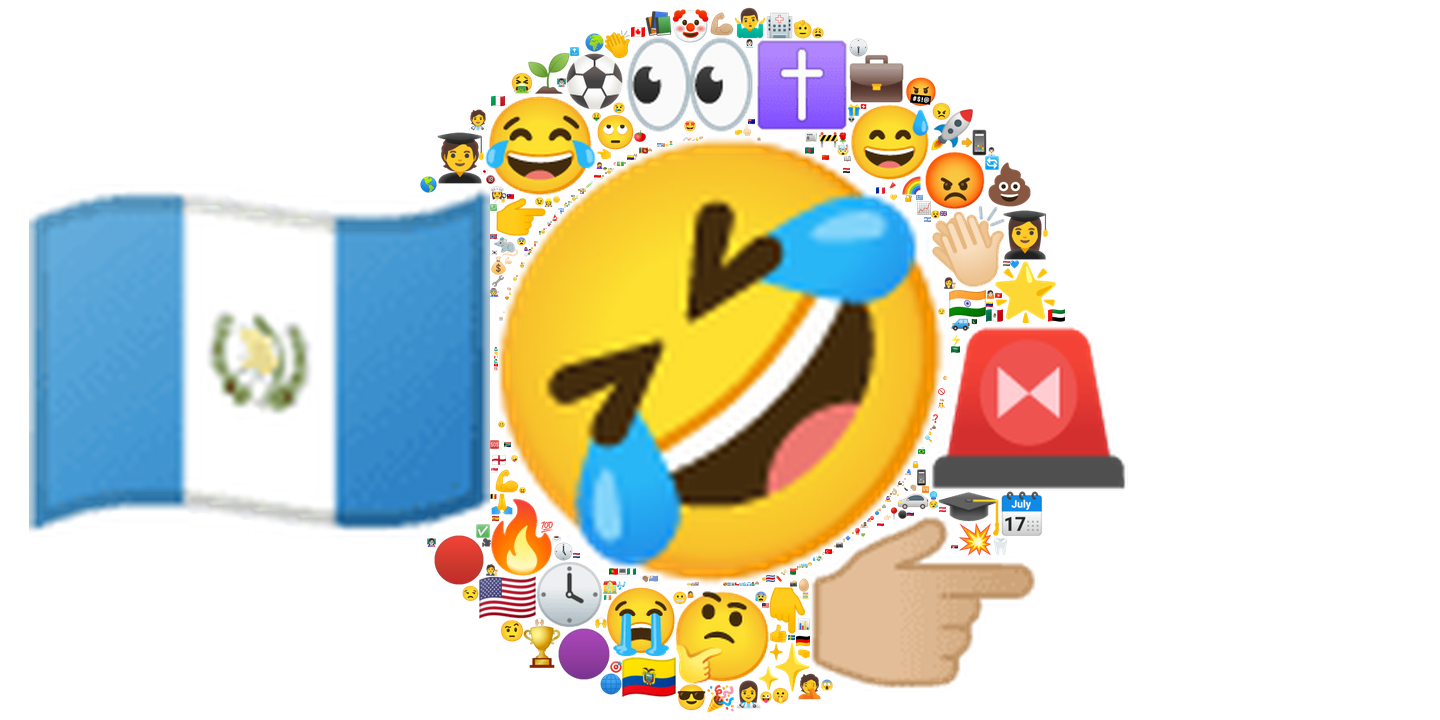

In [238]:
display(Markdown("## Emoticons Bernardo 1"))
display(Image(filename='bernardo_emoticons1.png'))

In [240]:
lista_bernardo2 = EmojiManager.create_list_from_single_vendor(bernardo_emoticons2, GOOGLE)

# rectangle canvas 
print("Plotting rectangle cloud")
canvas_w = 72*20
canvas_h = 72*10
canvas = RectangleCanvas(canvas_w, canvas_h)
saved_emoji_cloud_name = 'bernardo_emoticons2.png'
nube_bernardo2 = plot_dense_emoji_cloud(canvas, lista_bernardo2)
nube_bernardo2.save(saved_emoji_cloud_name)

Plotting rectangle cloud


[14:18:32] plot_emoji_cloud_given_relax_ratio took 235.8601                                              ]8;id=708119;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py\util.py]8;;\:]8;id=401838;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py#16\16]8;;\

           plot_dense_emoji_cloud took 237.8266                                                          ]8;id=423577;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py\util.py]8;;\:]8;id=751735;file://C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\EmojiCloud\util.py#16\16]8;;\

## Emoticons Bernardo 2

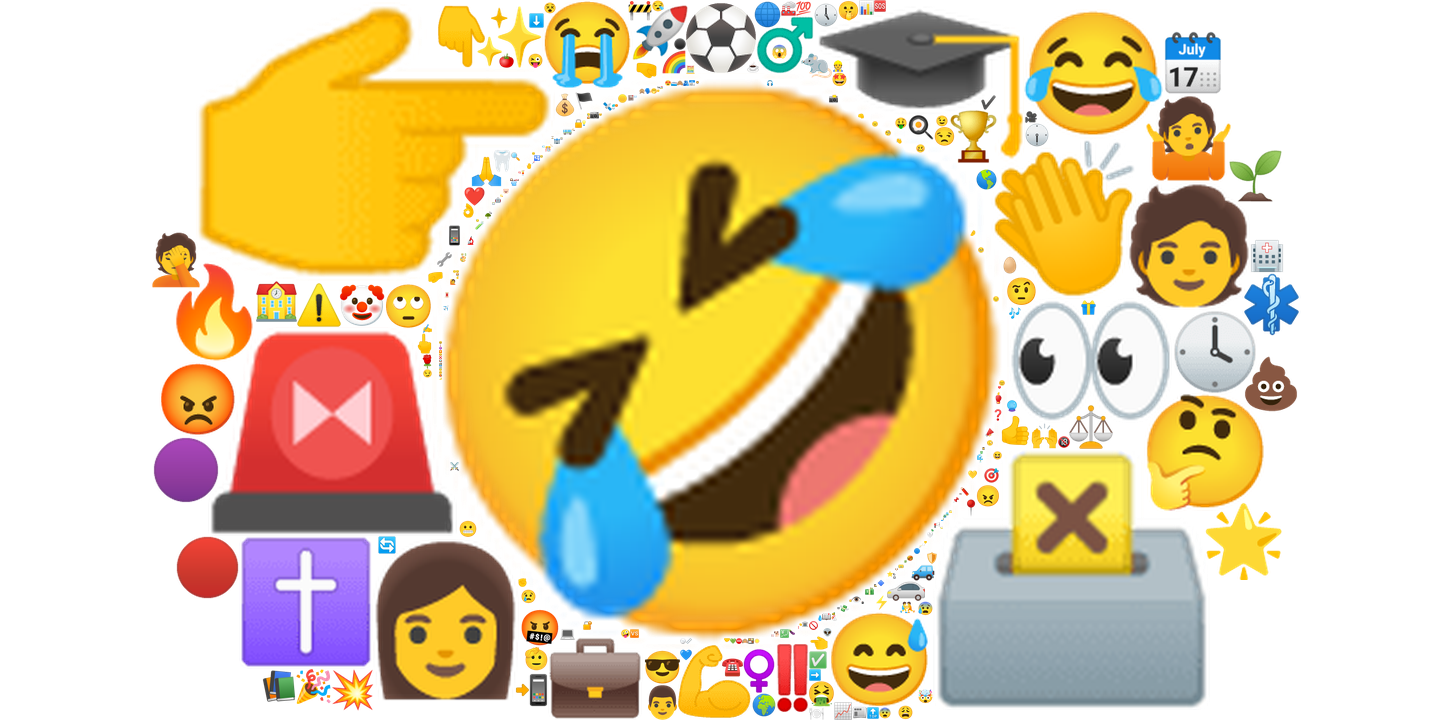

In [241]:
display(Markdown("## Emoticons Bernardo 2"))
display(Image(filename='bernardo_emoticons2.png'))

In [275]:
df['rawContent'] = df['rawContent'].apply(clean_tweets)
text_corpus_bernardo = ' '.join(df['rawContent'])

In [277]:
def remove_stop_words(tweet):
    removed_stop_words = ' '.join([word for word in tweet.split() if word not in spanish_stop_words])
    return removed_stop_words

In [278]:
df['tweetSinStopWords'] = df['rawContent'].apply(remove_stop_words)
text_corpus_bernardo_sin_stop = ' '.join(df['tweetSinStopWords'])

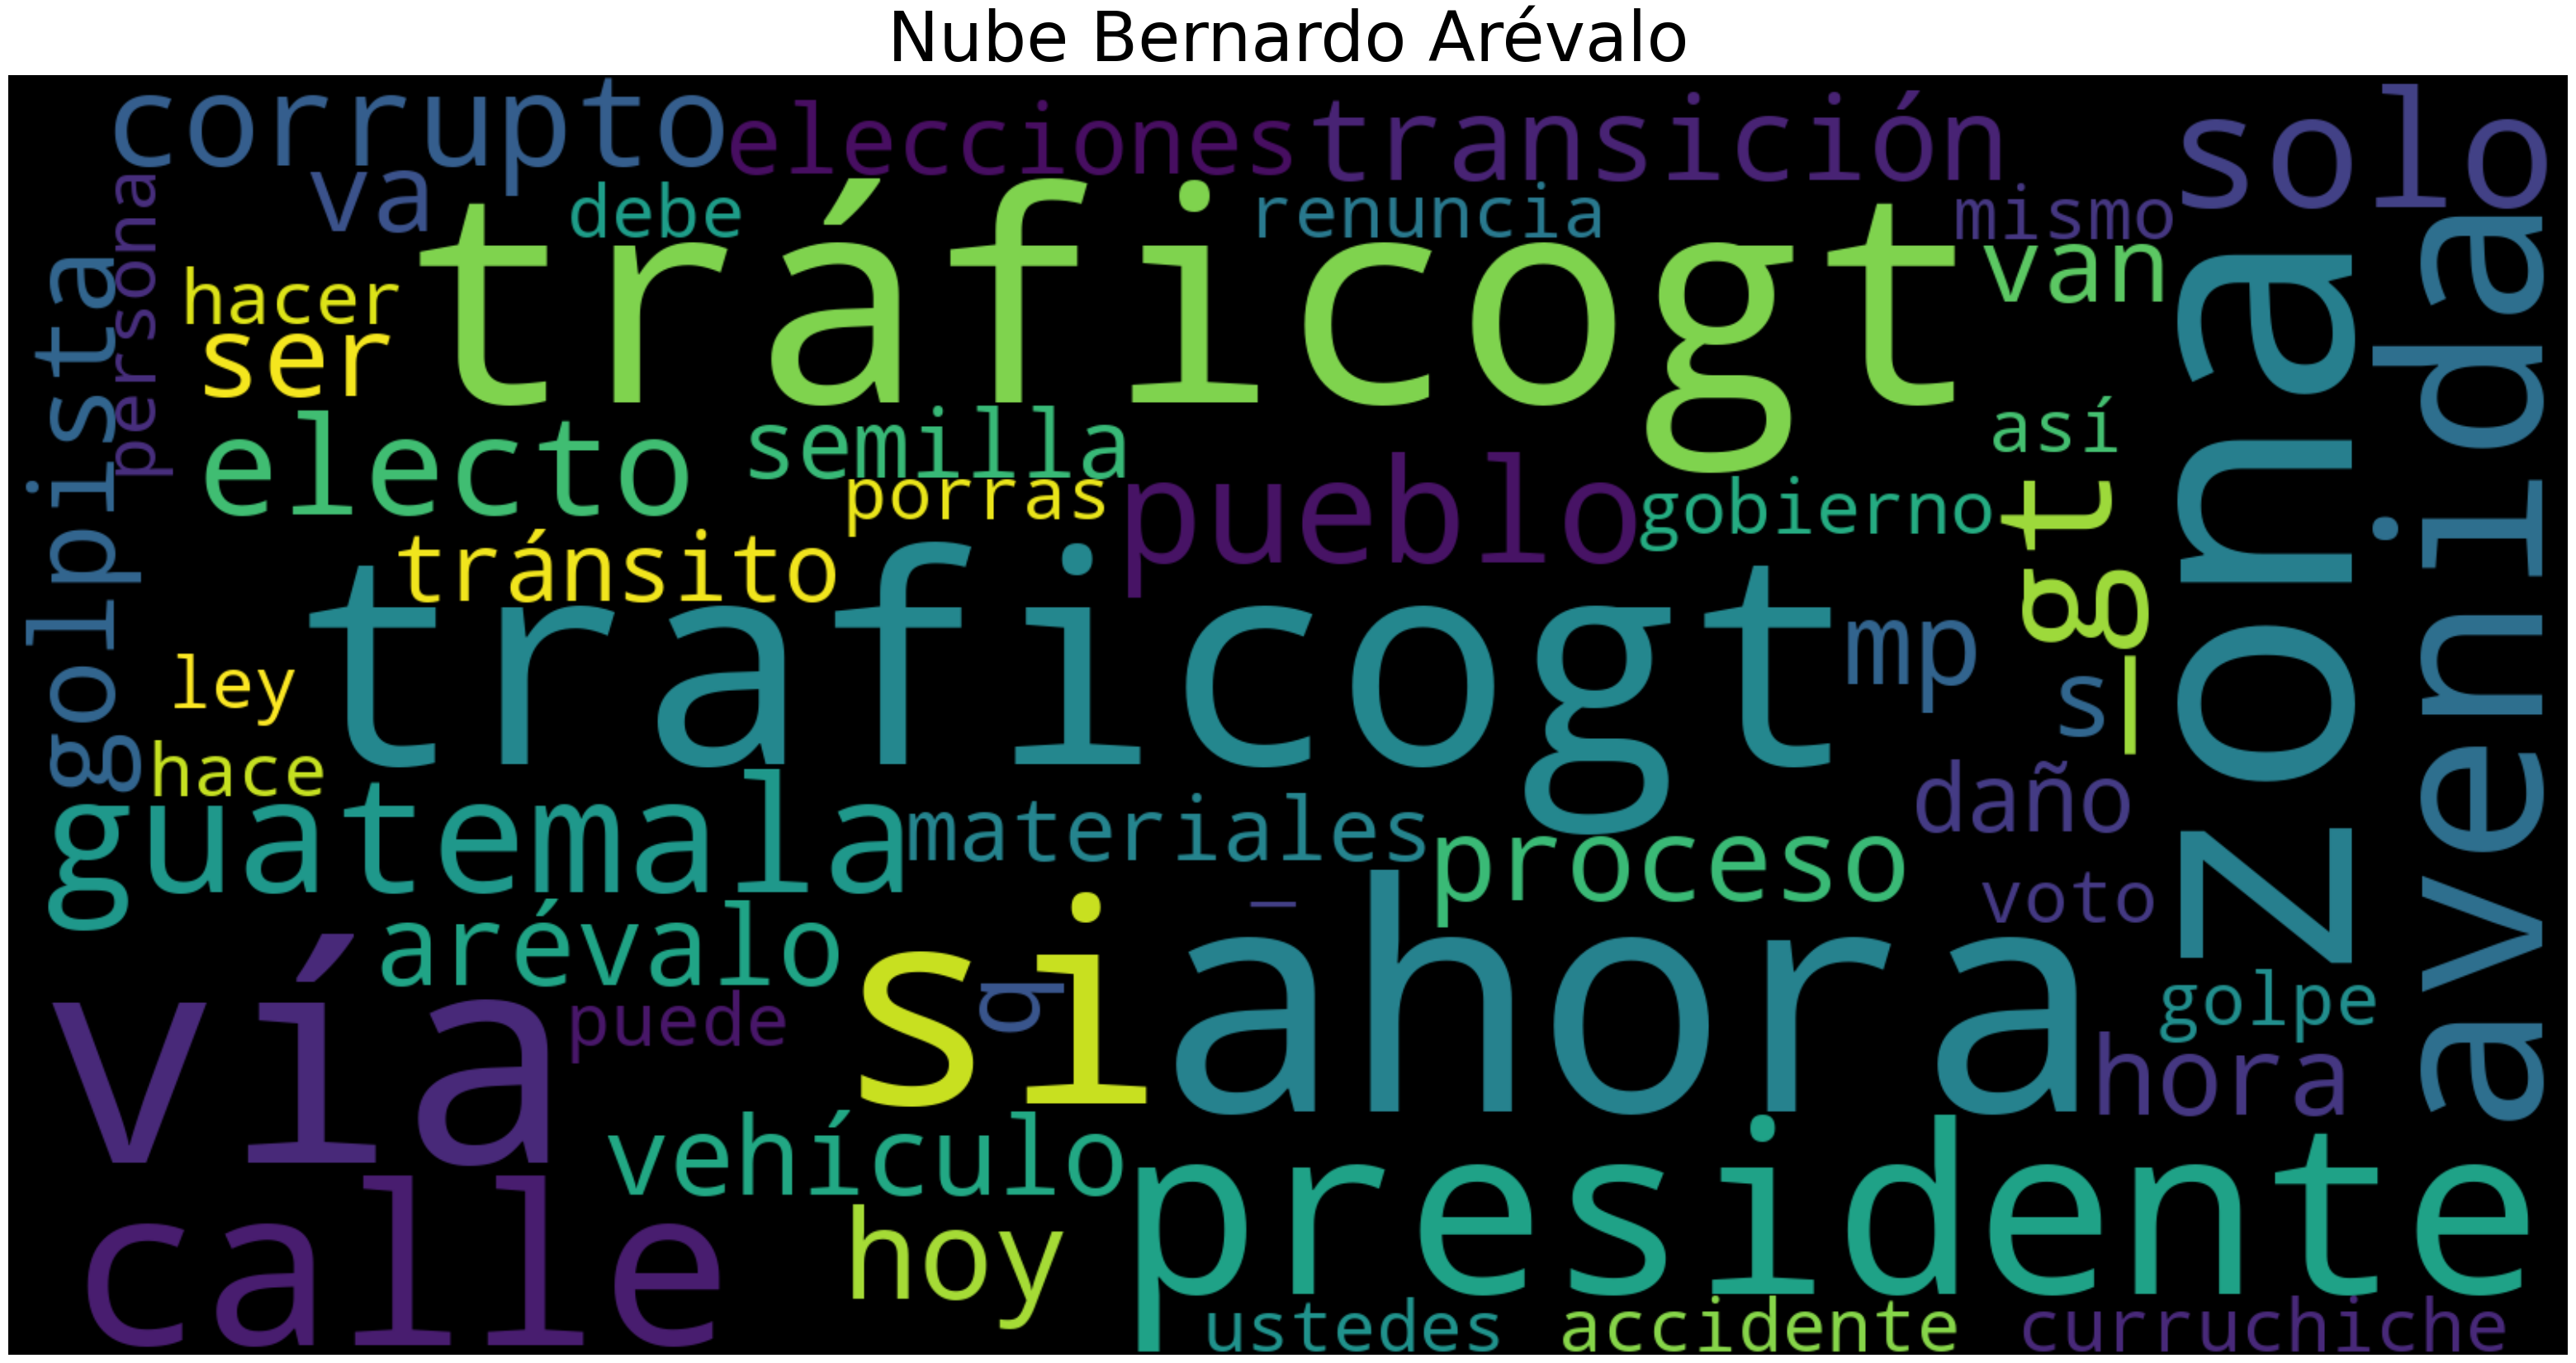

In [283]:
wordcloud = WordCloud(width=1600,height=800,max_font_size=200,max_words=50,
                      collocations=False, background_color='black').generate(text_corpus_bernardo_sin_stop)
plt.figure(figsize=(40,30))
plt.title("Nube Bernardo Arévalo", fontsize=60, color='black')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()